# Coding Interview Prep Exercise Unit 17.3

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday
period , identify which factors predict future user
adoption .
We suggest spending 1-2
hours on this, but you're welcome to spend more or less.
Please send us a brief writeup of your findings (the more concise, the better no
more
than one page), along with any summary tables, graphs, code, or queries that can help
us understand your approach. Please note any factors you considered or investigation
you did, even if they did not pan out. Feel free to identify any further research or data
you think would be valuable.

1] A user table ( "takehome_users" ) with data on 12,000 users who signed up for the
product in the last two years.

2] A usage summary table ( "takehome_user_engagement" ) that has a row for each day
that a user logged into the product.

In [1]:
# Mounting my drive on Google Colab
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# 1. Load and review data

In [3]:
# 1a Importing the 2 csv files; first file gets an error with defaults - had to change encoding

user_data = pd.read_csv('/content/drive/My Drive/data/takehome_users.csv', encoding='latin-1')
usage_data = pd.read_csv('/content/drive/My Drive/data/takehome_user_engagement.csv')

print(user_data.info())
print(usage_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Co

In [5]:
# 1b Showing first few lines of user data file; there are 12000 unique users (object_ids)

print("There are {} unique users (object_id field).".format(user_data['object_id'].nunique()))
user_data.head()

There are 12000 unique users (object_id field).


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [8]:
# 1c Showing info and first few lines of usage data file; there are only 8823 unique users (user_ids) and 207917 time_stamps

print("There are {} unique users (user_id field).".format(usage_data['user_id'].nunique()))
print("There are a total of {} time stamps.".format(len(usage_data['time_stamp'])))
print(usage_data.info())
usage_data.head()

There are 8823 unique users (user_id field).
There are a total of 207917 time stamps.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [ ]:
# 1d Showing stats of usage data file; visited field is a constant of 1

usage_data.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


# 2. Defining 'adopted user'

Pseudocode:

1. Convert login time to datetime index; can use the visited column as a count field
2. Groupby user_id while resampled time stamp to a week long interval to get a count of logins by user_id by week
3. Trying another method (rolling) to confirm 

In [9]:
#2.1  Convert login time to datetime index

usage_data_datetime = usage_data.set_index(pd.DatetimeIndex(usage_data['time_stamp']))
usage_data_datetime['time_stamp'] = pd.to_datetime(usage_data_datetime['time_stamp'])
print(usage_data_datetime.head(15))
usage_data_datetime.info()

                             time_stamp  user_id  visited
time_stamp                                               
2014-04-22 03:53:30 2014-04-22 03:53:30        1        1
2013-11-15 03:45:04 2013-11-15 03:45:04        2        1
2013-11-29 03:45:04 2013-11-29 03:45:04        2        1
2013-12-09 03:45:04 2013-12-09 03:45:04        2        1
2013-12-25 03:45:04 2013-12-25 03:45:04        2        1
2013-12-31 03:45:04 2013-12-31 03:45:04        2        1
2014-01-08 03:45:04 2014-01-08 03:45:04        2        1
2014-02-03 03:45:04 2014-02-03 03:45:04        2        1
2014-02-08 03:45:04 2014-02-08 03:45:04        2        1
2014-02-09 03:45:04 2014-02-09 03:45:04        2        1
2014-02-13 03:45:04 2014-02-13 03:45:04        2        1
2014-02-16 03:45:04 2014-02-16 03:45:04        2        1
2014-03-09 03:45:04 2014-03-09 03:45:04        2        1
2014-03-13 03:45:04 2014-03-13 03:45:04        2        1
2014-03-31 03:45:04 2014-03-31 03:45:04        2        1
<class 'pandas

In [11]:
#2.2a Groupby user_id while resampling time stamp to a week long interval to get a count of logins by user_id by week

grouped = usage_data_datetime.groupby('user_id').resample('W')['time_stamp'].count().reset_index(name="weekly_login_count_by_user")

grouped['time_stamp'] = pd.to_datetime(grouped['time_stamp'])
grouped.head(15)

,user_id,time_stamp,weekly_login_count_by_user
0,1,2014-04-27,1
1,2,2013-11-17,1
2,2,2013-11-24,0
3,2,2013-12-01,1
4,2,2013-12-08,0
5,2,2013-12-15,1
6,2,2013-12-22,0
7,2,2013-12-29,1
8,2,2014-01-05,1
9,2,2014-01-12,1


In [13]:
#2.2b Perform another groupby to get max count by user

grouped_user_login = grouped.groupby('user_id').max()
#grouped_user_login.head()
grouped_user_login.describe()

,weekly_login_count_by_user
count,8823.000000
mean,1.765613
std,1.695383
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,7.000000


In [14]:
#2.2c Then create a new columns 1/0 for adopted user with counts >= 3

grouped_user_login['adopted_user'] = np.where(grouped_user_login['weekly_login_count_by_user'] >= 3, 1, 0 )
grouped_user_login.drop(['time_stamp'], axis = 1, inplace = True)
grouped_user_login.head(15)
#grouped_user_login.describe()

,weekly_login_count_by_user,adopted_user
user_id,,
1,1,0
2,3,1
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
10,7,1
11,1,0


In [75]:
#2.2d - Qc of results

#grouped_user_login.describe()
#grouped_user_login.info()

print("Count of non-adopted users (0) and adopted users (1): ")
print(grouped_user_login['adopted_user'].value_counts())

print("There are a total of {} users in the usage file.".format(len(grouped_user_login['adopted_user'])))

print("This results in a {} percentage of adopted users in the usage file."
.format(round(grouped_user_login['adopted_user'].sum() / len(grouped_user_login['adopted_user']),4)*100))

Count of non-adopted users (0) and adopted users (1): 
0    7378
1    1445
Name: adopted_user, dtype: int64
There are a total of 8823 users in the usage file.
This results in a 16.38 percentage of adopted users in the usage file.


In [77]:
#2.3a Using a different method to verify first results - using rolling

def rolling_count(df, period):
    return df.rolling(period, on='time_stamp')['user_id'].count()

usage_data_datetime['visits_7_days'] = usage_data_datetime.groupby('user_id', as_index=False, group_keys=False).apply(rolling_count, '7D')

In [80]:
#2.3b Perform groupby to get max count by user

grouped_rolling = usage_data_datetime.groupby('user_id')[['visits_7_days']].max()
grouped_rolling.head()

,visits_7_days
user_id,
1,1.0
2,3.0
3,1.0
4,1.0
5,1.0


In [82]:
#2.3c Then create a new columns 1/0 for adopted user with counts >= 3

grouped_rolling['adopted_user'] = np.where(grouped_rolling['visits_7_days'] >= 3, 1, 0 )
grouped_rolling.head(15)

,visits_7_days,adopted_user
user_id,,
1,1.0,0
2,3.0,1
3,1.0,0
4,1.0,0
5,1.0,0
6,1.0,0
7,1.0,0
10,7.0,1
11,1.0,0


In [83]:
#2.3d - Qc of results; choosing to go with second approach as it is picking up additional adopted users with the rolling logic

print("Count of non-adopted users (0) and adopted users (1): ")
print(grouped_rolling['adopted_user'].value_counts())

print("There are a total of {} users in the usage file.".format(len(grouped_rolling['adopted_user'])))

print("This results in a {} percentage of adopted users in the usage file."
.format(round(grouped_rolling['adopted_user'].sum() / len(grouped_rolling['adopted_user']),4)*100))

Count of non-adopted users (0) and adopted users (1): 
0    7221
1    1602
Name: adopted_user, dtype: int64
There are a total of 8823 users in the usage file.
This results in a 18.16 percentage of adopted users in the usage file.


# 3. Identifying Which Factors predict future user adoption

Pseudocode
1. Merge adopted user info back into user df
2. EDA to understand relationships
3. Prep data for modelling
4. Perform predictive modelling - using classification type of algorithm
5. Identify features that best predict user adoption

In [95]:
#1 Merge adopted user info back into user df
merged_data = pd.merge(user_data, grouped_rolling, how = 'left', left_on='object_id', right_on='user_id')
merged_data.head(20)

#Fillnas in adopted user column with 0 since those users were not in login data and obviously never visited
merged_data['adopted_user'] = merged_data['adopted_user'].fillna(0)

Text(0.5, 0, 'adopted_user')

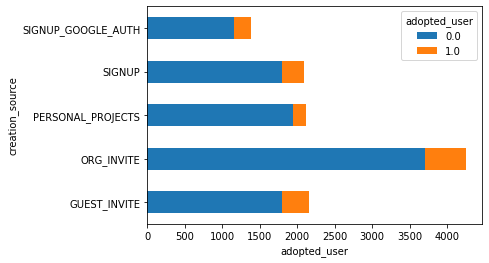

In [96]:
#2a. EDA to understand different relationships; all creation sources have some adopted users

adopted_creationsource = merged_data.groupby(['creation_source', 'adopted_user'])['creation_source'].count().unstack('adopted_user')
#adopted_creationsource.head()
adopted_creationsource.plot.barh(stacked='True')
plt.xlabel("adopted_user")

Text(0.5, 0, 'adoption_percentage')

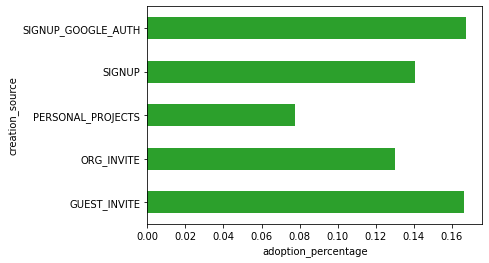

In [97]:
#2b. EDA to understand different relationships; guest_invite and signup creation sources have higher percentage of adopted users
# Personal Projects have the lowest adoption rate

adopted_creationsource['creationsource_adopt_pct'] = adopted_creationsource[1.0] / (adopted_creationsource[0.0] + adopted_creationsource[1.0])
adopted_creationsource.sort_values(by = 'creationsource_adopt_pct', ascending = False).head(5)
adopted_creationsource['creationsource_adopt_pct'].plot.barh(color=['C2'])
plt.xlabel("adoption_percentage")

Text(0.5, 1.0, 'Mean Enabled for Marketing Drip')

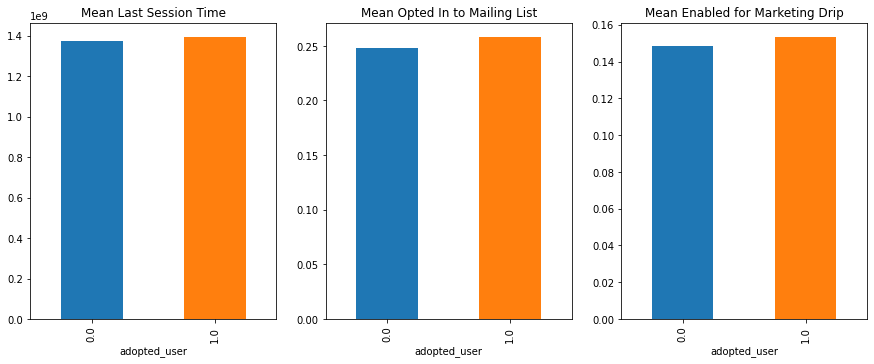

In [98]:
#2c. EDA - Plotting averages for other numeric columns by whether adopted_user or not; 
# adopted user means are only slightly higher in all categories

plt.figure(figsize=(15,12))
plt.tight_layout(pad = 50)

plt.subplot(2,3,1)
adopted_lastsessiontime = merged_data.groupby(by='adopted_user')['last_session_creation_time'].mean()
ax = adopted_lastsessiontime.plot.bar(color=['C0','C1'])
plt.xlabel("adopted_user")
ax.set_title('Mean Last Session Time')

plt.subplot(2,3,2)
adopted_opted_in = merged_data.groupby(by='adopted_user')['opted_in_to_mailing_list'].mean()
ax = adopted_opted_in.plot.bar(color=['C0','C1'])
plt.xlabel("adopted_user")
ax.set_title("Mean Opted In to Mailing List")

plt.subplot(2,3,3)
adopted_enabled = merged_data.groupby(by='adopted_user')["enabled_for_marketing_drip"].mean()
ax = adopted_enabled.plot.bar(color=['C0','C1'])
plt.xlabel("adopted_user")
ax.set_title("Mean Enabled for Marketing Drip")

Text(0.5, 0, 'adoption_percentage')

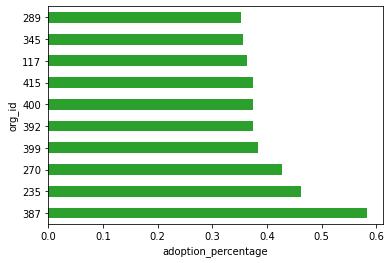

In [99]:
#2d. EDA - Look at adopted user percentages by org_id - some organizations are responsible for a higher percentage of adoptees

adopted_org_id = merged_data.groupby(['org_id', 'adopted_user'])['org_id'].count().unstack('adopted_user')
adopted_org_id['org_adopt_pct'] = adopted_org_id[1.0] / (adopted_org_id[0.0] + adopted_org_id[1.0])
top_adopted_orgs = adopted_org_id.sort_values(by = 'org_adopt_pct', ascending = False).head(10)

top_adopted_orgs['org_adopt_pct'].plot.barh(color=['C2'])
plt.xlabel("adoption_percentage")

Text(0.5, 0, 'adoption_percentage')

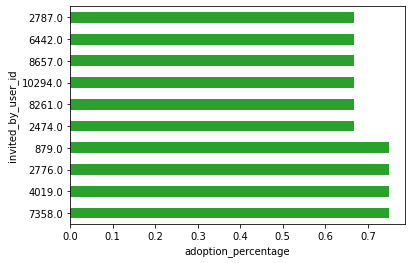

In [100]:
#2e. EDA -  Look at adopted user percentages by invited_by_user_id; some users are responsible for a higher percentage of adoptees
# this info may give us some ideas about new features we may want to add, but for sake of time, will only use the provided features

adopted_invited_by_user_id = merged_data.groupby(['invited_by_user_id', 'adopted_user'])['invited_by_user_id'].count().unstack('adopted_user')
adopted_invited_by_user_id['invited_by_user_adopt_pct'] = adopted_invited_by_user_id[1.0] / (adopted_invited_by_user_id[0.0] + adopted_invited_by_user_id[1.0])
top_adopted_invited_by_users = adopted_invited_by_user_id.sort_values(by = 'invited_by_user_adopt_pct', ascending = False).head(10)

top_adopted_invited_by_users['invited_by_user_adopt_pct'].plot.barh(color=['C2'])
plt.xlabel("adoption_percentage")

In [101]:
#3a. Prepping dataframe for modelling; Fillnas in other features? - invited_by_user_id and last_session_creation_time

merged_data['last_session_creation_time'] = merged_data['last_session_creation_time'].fillna(0)
merged_data['invited_by_user_id'] = merged_data['invited_by_user_id'].fillna(0)
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  12000 non-null  float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          12000 non-null  float64
 10  visits_7_days               8823 non-null   float64
 11  adopted_user                12000 non-null  float64
dtypes: float64(4), int64(4), object(4)
memory usage: 1.2+ MB


In [102]:
#3b. get dummies for the creation_source

merged_data = pd.get_dummies(merged_data, columns = ['creation_source'])
merged_data.head()

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visits_7_days,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803.0,1.0,0.0,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316.0,3.0,1.0,0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,1525.0,1.0,0.0,0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,5151.0,1.0,0.0,1,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1.358850e+09,0,0,193,5240.0,1.0,0.0,1,0,0,0,0


In [103]:
'''
#4a - create X and y set and split into train and test sets; not including creation time / last session creation time since we will not know these in advance 
for future users and we would expect there to be a colinearity between adopted users and their last login time since we used login times to id adopted users
also not including names or emails in the interest of time - although some additional features could be created from these (female vs male, domain names, etc)
'''
feature_columns = [ 
       'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH']

X = merged_data[feature_columns]
y = merged_data['adopted_user']

print(X.shape)
print(y.shape)

# Splitting into train, test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(12000, 9)
(12000,)
(8400, 9) (8400,)
(3600, 9) (3600,)


In [104]:
#4b instantiate model and fit to training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [107]:
#4b printing scores

print("score on train: " + str(round(xgb_model.score(X_train, y_train),3)))
print("score on test:  " + str(xgb_model.score(X_test, y_test)))

score on train: 0.867
score on test:  0.865


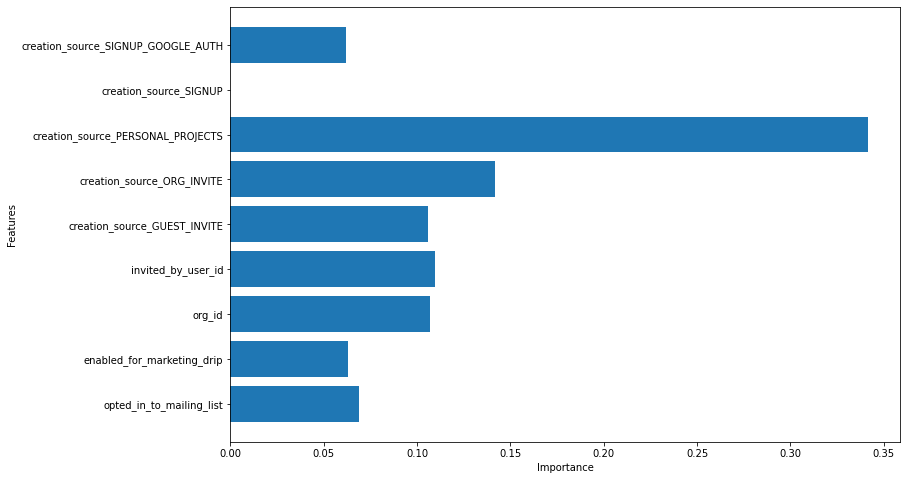

In [108]:
'''
 5 Identify most important features by plotting the feature importances 
# creation sources are all important; particularly those that are personal projects
We saw this correlation in the EDA above that the lowest percentage of adopted users was from the
personal projects group; so there appears to be a high inverse correlation
'''
feat_imp = xgb_model.feature_importances_
#print(feat_imp)
plt.figure(figsize=(12,8))
plt.barh(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
ycol = X.columns
plt.ylabel('Features')
plt.xlabel('Importance')
plt.yticks(range(len(ycol)), ycol.values)
plt.show()